In [6]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dropout, Dense, Concatenate, TimeDistributed, Attention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [ ]:
variables = pd.read_csv('processed_variables_engineered.csv', index_col=0, parse_dates=True)
print("Processed data loaded successfully.")

scaler_ws100 = MinMaxScaler()
scaler_other = MinMaxScaler()

variables_scaled = variables.copy()

ws100_columns = ['ws100_wavelet']
other_columns = variables.columns.drop('ws100_wavelet').tolist()

variables_scaled[ws100_columns] = scaler_ws100.fit_transform(variables[ws100_columns])
variables_scaled[other_columns] = scaler_other.fit_transform(variables[other_columns])

print(f"Shape of scaled data: {variables_scaled.shape}")


input_steps = 36  
output_steps = 36  

def create_sequences(data, input_steps, output_steps, target_col_index):
    """
    Create input and output sequences for the Seq2Seq model using Teacher forcing.
    """
    X_encoder = []
    X_decoder = []
    y_decoder = []
    
    for i in range(len(data) - input_steps - output_steps + 1):
        X_encoder.append(data[i:(i + input_steps)])
        
        decoder_input = np.zeros((output_steps, 1))
        
        decoder_input[0] = data[i + input_steps - 1, target_col_index]
        
        decoder_input[1:] = data[i + input_steps:i + input_steps + output_steps - 1, target_col_index].reshape(-1, 1)
        
        X_decoder.append(decoder_input)
        
        y_decoder.append(data[i + input_steps:i + input_steps + output_steps, target_col_index].reshape(-1, 1))
    
    return np.array(X_encoder), np.array(X_decoder), np.array(y_decoder)

data_array = variables_scaled.values

target_col_index = variables_scaled.columns.get_loc('ws100_wavelet')

X_encoder, X_decoder, y_decoder = create_sequences(data_array, input_steps, output_steps, target_col_index)


print(f"Shape of X_encoder: {X_encoder.shape}")
print(f"Shape of X_decoder: {X_decoder.shape}")
print(f"Shape of y_decoder: {y_decoder.shape}")

train_end = int(X_encoder.shape[0] * 0.77)
val_end = int(X_encoder.shape[0] * 0.95)

X_encoder_train = X_encoder[:train_end]
X_decoder_train = X_decoder[:train_end]
y_decoder_train = y_decoder[:train_end]

X_encoder_val = X_encoder[train_end:val_end]
X_decoder_val = X_decoder[train_end:val_end]
y_decoder_val = y_decoder[train_end:val_end]

X_encoder_test = X_encoder[val_end:]
X_decoder_test = X_decoder[val_end:]
y_decoder_test = y_decoder[val_end:]

print(f"Training X_encoder: {X_encoder_train.shape}, Training X_decoder: {X_decoder_train.shape}, Training y_decoder: {y_decoder_train.shape}")
print(f"Validation X_encoder: {X_encoder_val.shape}, Validation X_decoder: {X_decoder_val.shape}, Validation y_decoder: {y_decoder_val.shape}")
print(f"Test X_encoder: {X_encoder_test.shape}, Test X_decoder: {X_decoder_test.shape}, Test y_decoder: {y_decoder_test.shape}")

num_encoder_features = X_encoder_train.shape[2]
num_decoder_features = 1  

def build_seq2seq_attention_model(input_steps, output_steps, num_encoder_features, num_decoder_features):
    """
    Builds a Seq2Seq model with attention mechanism using Bidirectional LSTM.
    """
    optimizer = Adam(learning_rate=1e-3)
    
    encoder_inputs = Input(shape=(input_steps, num_encoder_features), name='encoder_inputs')
    
    encoder_lstm = Bidirectional(LSTM(256, return_sequences=True, return_state=True), name='bidirectional_encoder_lstm')
    encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm(encoder_inputs)
    
    state_h = Concatenate()([forward_h, backward_h])
    state_c = Concatenate()([forward_c, backward_c])
    
    
    encoder_outputs = Dropout(0.1)(encoder_outputs)
    
    decoder_inputs = Input(shape=(output_steps, num_decoder_features), name='decoder_inputs')
    
    decoder_lstm = LSTM(256 * 2, return_sequences=True, return_state=True, name='decoder_lstm')
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=[state_h, state_c])
    
    decoder_outputs = Dropout(0.1)(decoder_outputs)
    
    attention_layer = Attention(name='attention_layer')
    attention_outputs = attention_layer([decoder_outputs, encoder_outputs])
    
    decoder_combined_context = Concatenate(axis=-1)([decoder_outputs, attention_outputs])
    
    decoder_dense = TimeDistributed(Dense(1, activation='linear'), name='output_layer')
    decoder_outputs_final = decoder_dense(decoder_combined_context)
    
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs_final)
    
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

model = build_seq2seq_attention_model(input_steps, output_steps, num_encoder_features, num_decoder_features)

model.summary()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
    ModelCheckpoint('best_model.h5.keras', monitor='val_loss', save_best_only=True)
]

history = model.fit(
    [X_encoder_train, X_decoder_train], y_decoder_train, 
    epochs=100,  
    batch_size=32, 
    validation_data=([X_encoder_val, X_decoder_val], y_decoder_val),
    callbacks=callbacks,
    verbose=1
)



Processed data loaded successfully.
Shape of scaled data: (7561, 9)
Shape of X_encoder: (7370, 156, 9)
Shape of X_decoder: (7370, 36, 1)
Shape of y_decoder: (7370, 36, 1)
Training X_encoder: (5674, 156, 9), Training X_decoder: (5674, 36, 1), Training y_decoder: (5674, 36, 1)
Validation X_encoder: (1327, 156, 9), Validation X_decoder: (1327, 36, 1), Validation y_decoder: (1327, 36, 1)
Test X_encoder: (369, 156, 9), Test X_decoder: (369, 36, 1), Test y_decoder: (369, 36, 1)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 156, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_enco… │ [(None, 156,      │    544,768 │ encoder_inputs[0… │
│ (Bidirectional)     │ 512), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 36, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 512)       │          0 │ bidirectional_en… │
│ (Concatenate)       │                   │            │ bidirectional_en… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 512)       │          0 │ bidirectional_en… │
│ (Concatenate)       │                   │            │ bidirectional_en… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 36, 512), │  1,052,672 │ decoder_inputs[0… │
│                     │ (None, 512),      │            │ concatenate_3[0]… │
│                     │ (None, 512)]      │            │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 36, 512)   │          0 │ decoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 156, 512)  │          0 │ bidirectional_en… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 36, 512)   │          0 │ dropout_3[0][0],  │
│ (Attention)         │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 36, 1024)  │          0 │ dropout_3[0][0],  │
│ (Concatenate)       │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 36, 1)     │      1,025 │ concatenate_5[0]… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,598,465 (6.10 MB)

 Trainable params: 1,598,465 (6.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['encoder_inputs', 'decoder_inputs']. Received: the structure of inputs=('*', '*')
  warnings.warn(


178/178 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - loss: 0.0301 - mae: 0.1138 - val_loss: 0.0026 - val_mae: 0.0383 - learning_rate: 0.0010
Epoch 2/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - loss: 0.0032 - mae: 0.0418 - val_loss: 0.0014 - val_mae: 0.0279 - learning_rate: 0.0010
Epoch 3/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 15s 85ms/step - loss: 0.0018 - mae: 0.0304 - val_loss: 7.5279e-04 - val_mae: 0.0203 - learning_rate: 0.0010
Epoch 4/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - loss: 9.7277e-04 - mae: 0.0230 - val_loss: 4.2530e-04 - val_mae: 0.0152 - learning_rate: 0.0010
Epoch 5/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 6.8292e-04 - mae: 0.0195 - val_loss: 3.5006e-04 - val_mae: 0.0144 - learning_rate: 0.0010
Epoch 6/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - loss: 4.8819e-04 - mae: 0.0164 - val_loss: 1.9530e-04 - val_mae: 0.0101 - learning_rate: 0.0010
Epoch 7/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - loss: 4.0462e-04 - mae: 0.0150 - val_loss: 1.4716e-04 - v

In [8]:
def rolling_forecasting_real_time_improved(model, data_scaled, input_steps, output_steps, scaler_ws100, target_col_index):
    """
    Realiza rolling forecasting simulando um cenário de previsão em tempo real com feedback do decoder.
    
    :param model: Modelo treinado.
    :param data_scaled: Dados escalonados (inclui treino, validação e teste).
    :param input_steps: Número de passos de entrada.
    :param output_steps: Número de passos de saída.
    :param scaler_ws100: Escalador para a coluna 'ws100_wavelet'.
    :param target_col_index: Índice da coluna alvo.
    :return: Arrays com previsões e valores reais.
    """
    predictions = []
    actuals = []
    
    test_start = int(data_scaled.shape[0] * 0.95) 
    test_data = data_scaled[test_start:]
    
    window_start = test_start - input_steps
    window_end = test_start
    window = data_scaled[window_start:window_end].copy()
    
    for i in range(len(test_data) - output_steps + 1):
        encoder_input = window.reshape(1, input_steps, data_scaled.shape[1])
        
        decoder_input = np.zeros((1, output_steps, 1))
        
        decoder_input[0, 0, 0] = encoder_input[0, -1, target_col_index]
        
        for t in range(1, output_steps):
            previous_pred = decoder_input[0, t-1, 0]
            decoder_input[0, t, 0] = previous_pred
        
        pred = model.predict([encoder_input, decoder_input])
        
        last_pred = pred[0, -1, 0]
        predictions.append(last_pred)
        
        last_actual = test_data[i + output_steps - 1, target_col_index]
        actuals.append(last_actual)
        
        window = np.vstack([window, test_data[i + output_steps - 1]])
        window = window[1:] 
    
    predictions = np.array(predictions).reshape(-1, 1)
    actuals = np.array(actuals).reshape(-1, 1)
    
    predictions_inverse = scaler_ws100.inverse_transform(predictions)
    actuals_inverse = scaler_ws100.inverse_transform(actuals)
    
    return predictions_inverse, actuals_inverse

In [9]:
# Executando a previsão rolling com a função simplificada
predictions, actuals = rolling_forecasting_real_time_improved(
    model, 
    data_scaled=variables_scaled.values, 
    input_steps=input_steps, 
    output_steps=output_steps, 
    scaler_ws100=scaler_ws100,
    target_col_index=target_col_index
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━

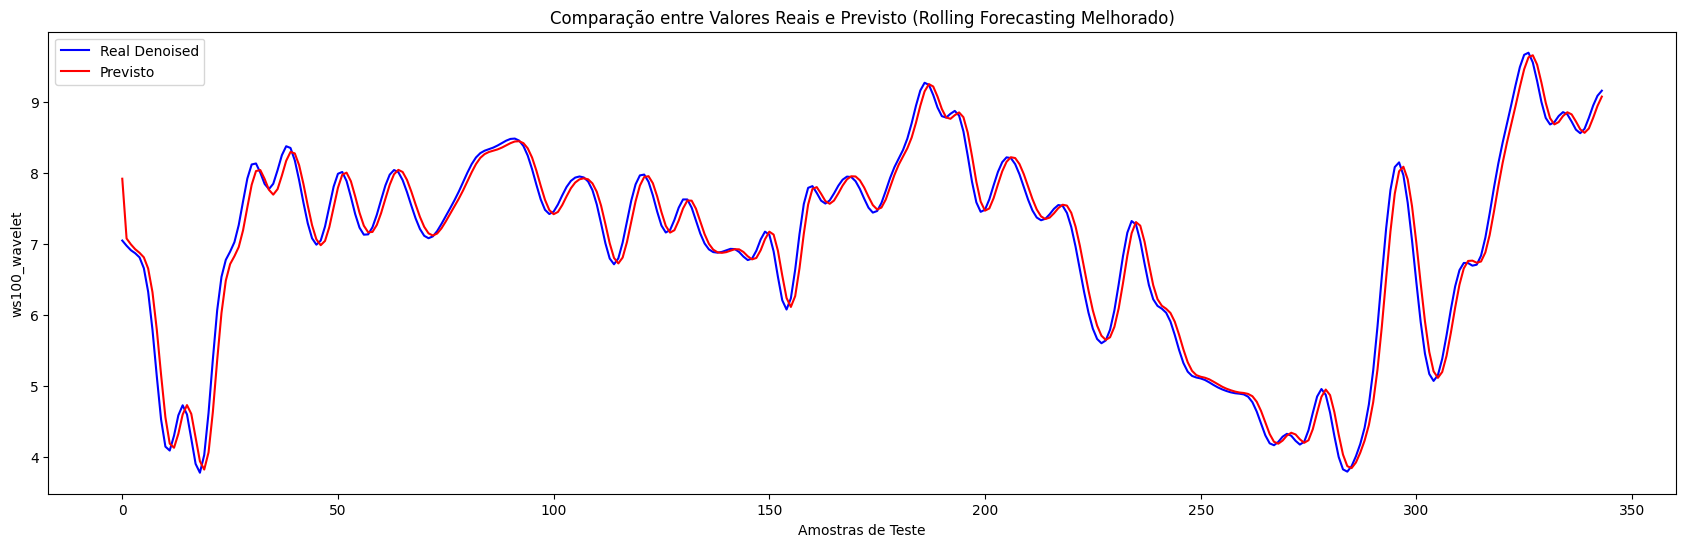

Mean Absolute Error (MAE): 0.1647
Mean Squared Error (MSE): 0.0477
Root Mean Squared Error (RMSE): 0.2185


In [10]:
plt.figure(figsize=(21, 6))
plt.plot(actuals, label='Real Denoised', color='blue')
plt.plot(predictions, label='Previsto', color='red')
plt.title('Comparação entre Valores Reais e Previsto (Rolling Forecasting Melhorado)')
plt.xlabel('Amostras de Teste')
plt.ylabel('ws100_wavelet')
plt.legend()
plt.show()

# Calculando e exibindo métricas de desempenho
mae = mean_absolute_error(actuals, predictions)
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")